In [15]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import *
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_state_city
from ibm_quantum_widgets import *

In [16]:
def diffuser(n):
    qc = QuantumCircuit(n)
    for qubit in range(n):
        qc.h(qubit)
    for qubit in range(n):
        qc.x(qubit)
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)
    
    for qubit in range(n):
        qc.x(qubit)
    for qubit in range(n):
        qc.h(qubit)
    
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [17]:
def vertexcolor_oracle(qc, v_list, e_list):
    #qc.x(in_qubits_v[3])
    #qc.x(in_qubits_v[4])
    #qc.x(in_qubits_v[7])


    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    '''
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])
    '''
    #check two number are not same
    i = 0
    for e in e_list:
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        i += 3

    '''
    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()
    '''

    #target
    check_qubitslist = []
    for j in range(len(e_list)):
        check_qubitslist.append(ax_qubits_e[j*3+2])
    '''
    for j in range(len(v_list)):
        check_qubitslist.append(check4_qubits[j])
    '''
    qc.mct(check_qubitslist, target[0])
    qc.barrier()

    #reverse part
    '''
    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()
    '''
    #check two number are not same
    e_list_r = e_list[::-1]
    i = 3*(len(e_list) - 1)
    for e in e_list_r:
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        i -= 3

    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    '''        
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])
    '''    
    qc.barrier()

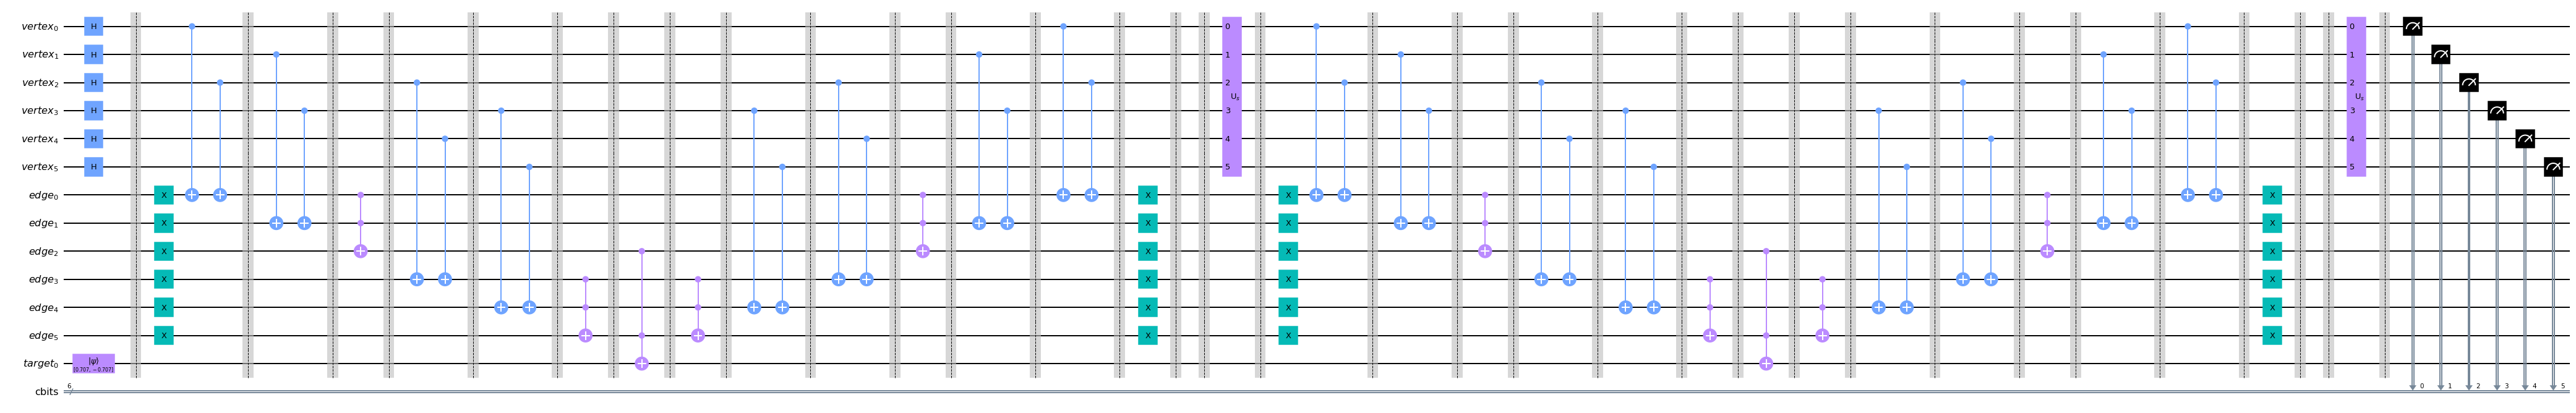

In [21]:
#example (v為vertex, e為edge)
v_list = [0,1,2]
e_list = [[0,1], [1,2]]

#input vertex qubits
in_qubits_v = QuantumRegister(2*len(v_list), name = 'vertex')
#auxiliary qubits (edge)
ax_qubits_e = QuantumRegister(3*len(e_list), name = 'edge')
#因為這裡是做3-coloring，第四個顏色的答案要捨去
'''
check4_qubits = QuantumRegister(len(v_list), name = 'not4')
'''
#target qubit
target = QuantumRegister(1, name = 'target')
#cbit:輸出結果
cbits = ClassicalRegister(2*len(v_list), name = 'cbits')


#qc = QuantumCircuit(in_qubits_v, ax_qubits_e, check4_qubits, target, cbits)
qc = QuantumCircuit(in_qubits_v, ax_qubits_e,  target, cbits)

#initialize 'target' as |->
qc.initialize([1, -1]/np.sqrt(2), target)

#parallelization
qc.h(in_qubits_v)
qc.barrier()

#oracle
vertexcolor_oracle(qc, v_list, e_list)
qc.barrier()

#diffuser
qc.append(diffuser(2*len(v_list)), list(range(2*len(v_list))))
qc.barrier()

#可以自行決定要run幾次(每個例子都會有不一樣的最佳次數)

#oracle
vertexcolor_oracle(qc, v_list, e_list)
qc.barrier()

#diffuser
qc.append(diffuser(2*len(v_list)), list(range(2*len(v_list))))
qc.barrier()


#measure
qc.measure(in_qubits_v, cbits)

qc.draw(output='mpl', fold = -1)

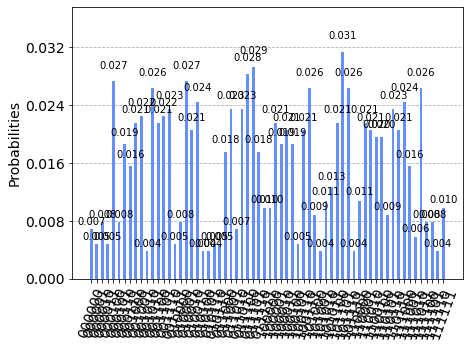

In [22]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
qobj = assemble(transpiled_qc)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

In [23]:
print(counts)

{'000001': 5, '000011': 5, '100000': 10, '101001': 4, '101000': 9, '001110': 24, '111010': 6, '000000': 7, '101011': 13, '011110': 18, '110101': 9, '001101': 23, '001111': 5, '010010': 21, '001001': 23, '110111': 21, '011100': 29, '110001': 22, '000111': 16, '010000': 8, '001100': 22, '111011': 27, '101111': 4, '010101': 4, '110000': 11, '100100': 19, '001010': 4, '000010': 8, '101101': 32, '001000': 22, '110100': 20, '000110': 19, '100110': 21, '111001': 16, '111000': 25, '010100': 4, '011000': 18, '100011': 21, '010111': 5, '101110': 27, '100111': 27, '010011': 25, '000101': 8, '110011': 20, '111100': 8, '101100': 22, '001011': 27, '111101': 8, '011001': 24, '011101': 30, '110010': 21, '010110': 5, '111111': 10, '100010': 19, '011111': 10, '100101': 5, '100001': 22, '010001': 28, '000100': 28, '110110': 24, '011011': 24, '111110': 4, '011010': 7, '101010': 11}
